In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os

# Import TDA pipeline requirements
import gudhi as gd
import json

from scipy import ndimage, interpolate

In [58]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [2]:
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
ksrc = '../kde/'
csrc = '../data/'
dst = '../gudhi/'

sample = 'D2'

ksrc += sample + os.sep
sdst = dst + sample + os.sep
if not os.path.isdir(sdst):
    os.mkdir(sdst)

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
nuclei = tf.imread(nsrc + sample + '_EDT.tif') < 2
label, cellnum = ndimage.label(wall, struc1)
wall[nuclei] = False
print('Detected',cellnum,'cells')

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = sorted([foo.split('/')[-2] for foo in glob(ksrc + '*/')])
print(len(transcriptomes), 'transcriptomes')

Detected 2937 cells
97 transcriptomes


In [117]:
tidx = 0
kdefiles = glob(ksrc + transcriptomes[tidx] + os.sep + '*.npy')
ratios = transcell.iloc[tidx, :-1].values.astype(float) / metatrans.loc[tidx, 'cyto_number']

metakde = np.zeros((len(kdefiles), 4), dtype=int)
rawkdemax = np.zeros(len(metakde))
for i in range(len(kdefiles)):
    foo = (os.path.splitext(os.path.split(kdefiles[i])[1])[0]).split('_')
    for j in range(metakde.shape[1]):
        metakde[i,j] = int(foo[j][1:])
    rawkdemax[i] = float(foo[-1][1:])
metakde = pd.DataFrame(metakde, columns=['ndimage_cellID', 'pad', 'stepsize', 'bandwidth'])
metakde['rawkdemax'] = rawkdemax
metakde['ratio'] = ratios[metakde['ndimage_cellID'].values]
metakde['kdemax'] = metakde['rawkdemax']*metakde['ratio']
metakde = metakde[metakde['ndimage_cellID'] != 0]

vmax = np.max(metakde['kdemax'])

print(metakde.shape)
metakde.sort_values(by='kdemax', ascending=False).head(10)

(966, 7)


,ndimage_cellID,pad,stepsize,bandwidth,rawkdemax,ratio,kdemax
867,803,6,5,15,0.000159,0.001337,2.125273e-07
517,1185,6,5,15,0.000099,0.002114,2.099301e-07
530,436,6,5,15,0.000181,0.001150,2.076277e-07
779,1354,6,5,15,0.000070,0.002269,1.591580e-07
797,1730,6,5,15,0.000130,0.001181,1.537219e-07
42,300,6,5,15,0.000093,0.001647,1.525194e-07
59,2149,6,5,15,0.000053,0.002704,1.439647e-07
103,1587,6,5,15,0.000160,0.000808,1.290834e-07
125,334,6,5,15,0.000412,0.000311,1.282165e-07
533,941,6,5,15,0.000589,0.000218,1.281118e-07


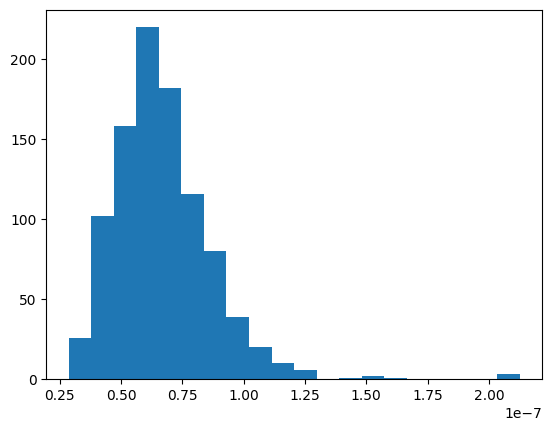

In [118]:
plt.hist(metakde['kdemax'], bins=20);

In [4]:
idx = 797
cidx = metakde.loc[idx,'ndimage_cellID']
kde = np.load(kdefiles[idx], allow_pickle=True)

In [82]:
PP = metakde.loc[idx, 'pad']
stepsize = metakde.loc[idx, 'stepsize']
ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wall.shape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wall.shape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
cy = ss[0].stop - ss[0].start
cx = ss[1].stop - ss[1].start
xaxis = np.arange(0, cx, stepsize); yaxis = np.arange(0, cy, stepsize)
xaxis += ss[1].start; yaxis += ss[0].start

In [124]:
cp = cartesian_product(np.arange(yaxis[0],yaxis[-1]), np.arange(xaxis[0],xaxis[-1]))
interp = interpolate.RegularGridInterpolator((yaxis, xaxis), kde, method='linear', bounds_error=True, fill_value=None)
img = interp(cp)
img = np.digitize(img, bins, right=True).astype(np.uint8).reshape(yaxis[-1]-yaxis[0],xaxis[-1]-xaxis[0])

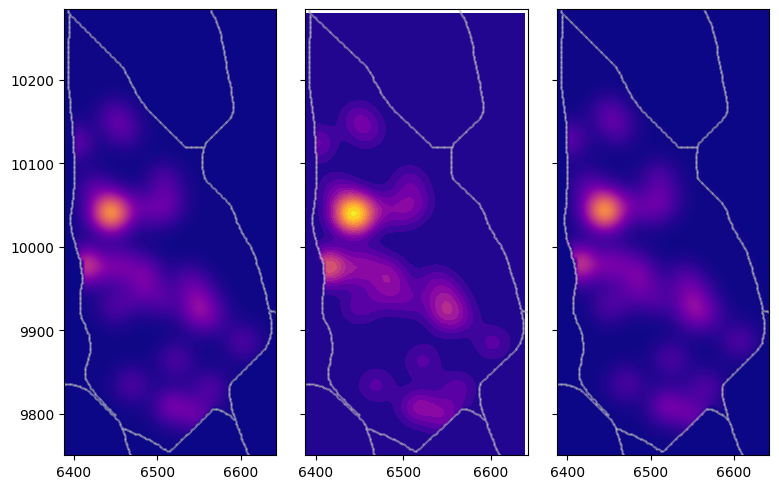

In [125]:
fs = 15
fig, ax = plt.subplots(1,3,figsize=(8,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(dig, cmap='plasma', origin='lower', extent=extent, vmin=0, vmax=255)
ax[1].contourf(xaxis, yaxis, kde, 16, cmap='plasma')
ax[2].imshow(bar, cmap='plasma', origin='lower', extent=extent, vmin=0, vmax=255)

for i in range(len(ax)):
    ax[i].scatter(bcoords[1], bcoords[0], c='silver', marker='.', s=1, alpha=0.5)
    
fig.tight_layout();

In [35]:
bcoords = np.asarray(np.nonzero(~wall[ss]))
bcoords[0] += ss[0].start; bcoords[1] += ss[1].start

# Match cells

In [126]:
cc = gd.CubicalComplex(top_dimensional_cells = bar)
pers = cc.persistence(homology_coeff_field=2, min_persistence=1)
pers

[(1, (1.0, 185.0)),
 (1, (30.0, 106.0)),
 (1, (10.0, 56.0)),
 (1, (35.0, 76.0)),
 (1, (9.0, 43.0)),
 (1, (15.0, 38.0)),
 (1, (15.0, 27.0)),
 (1, (15.0, 27.0)),
 (1, (17.0, 28.0)),
 (1, (49.0, 52.0)),
 (1, (58.0, 61.0)),
 (0, (0.0, inf)),
 (0, (3.0, 5.0))]

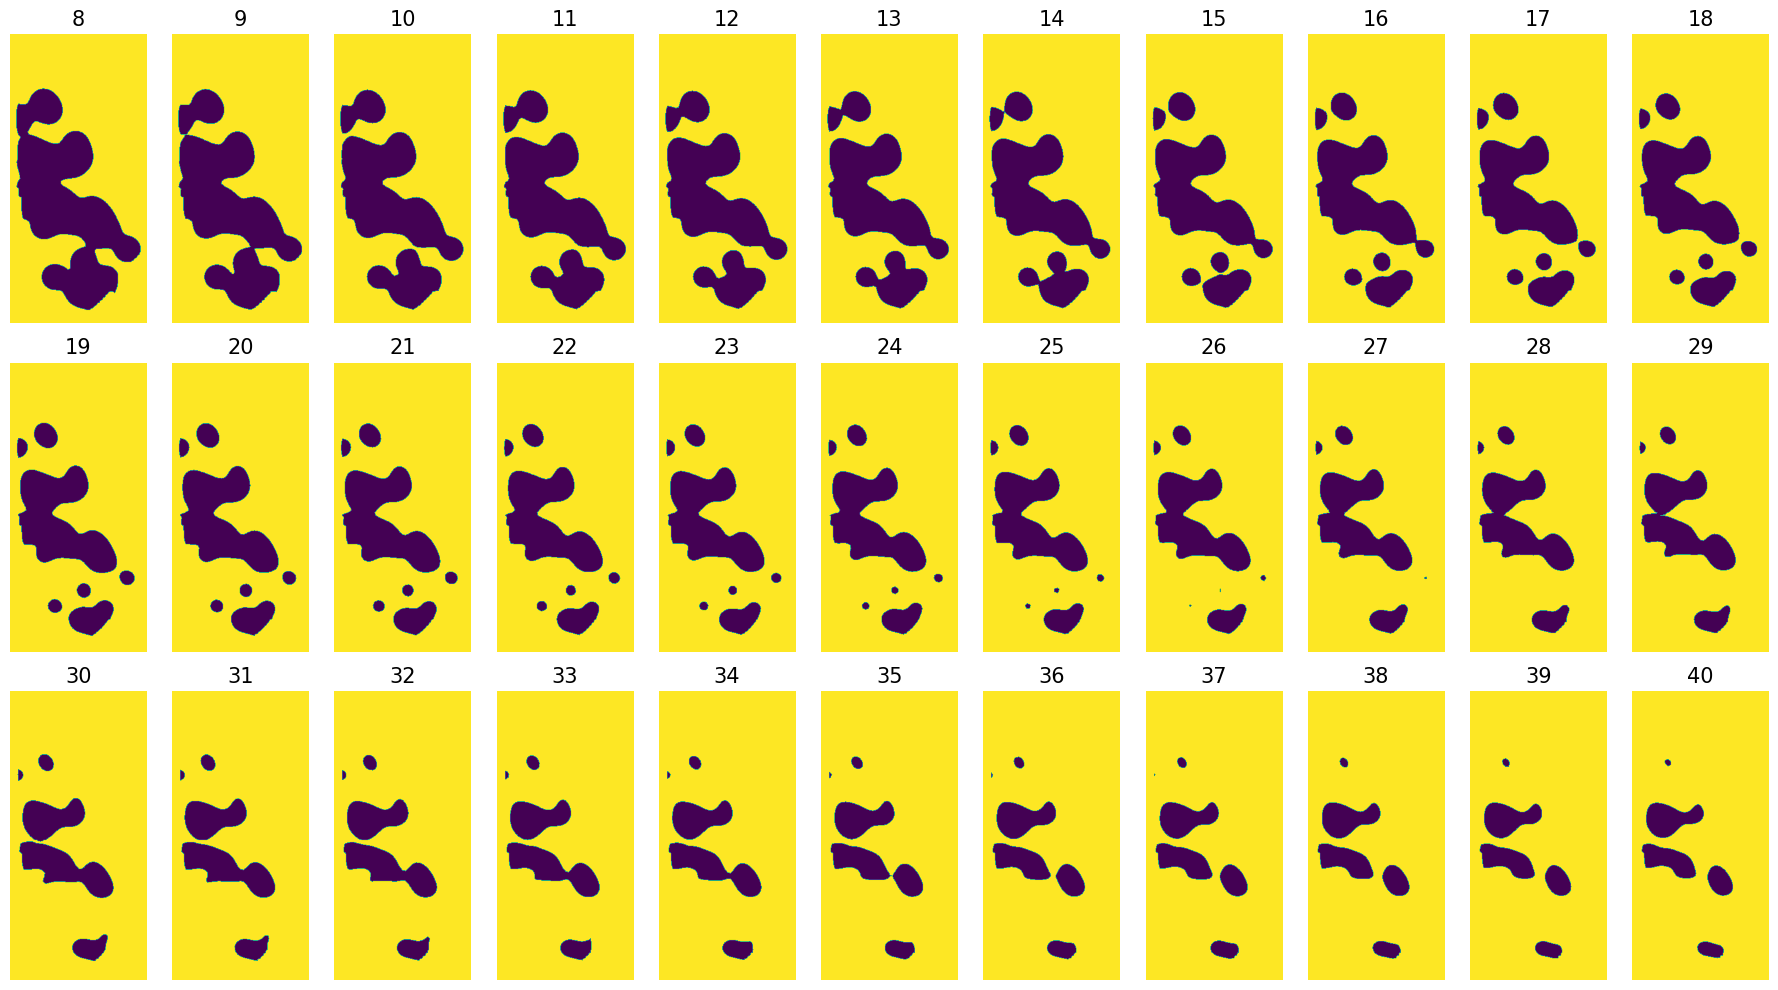

In [130]:
fig, ax = plt.subplots(3,11, figsize=(18,10), sharex=True, sharey=True)
ax = ax.ravel()
k = 8

for i in range(len(ax)):
    ax[i].imshow(img <= k + i, vmin=0, vmax=1, origin='lower');
    ax[i].set_title(k + i, fontsize=15)
    ax[i].axis('off');

fig.tight_layout();

In [141]:
maxv = img.max()
cc = gd.CubicalComplex(top_dimensional_cells = maxv-img)
pers = cc.persistence(homology_coeff_field=2, min_persistence=1)
pers

[(1, (180.0, 182.0)),
 (0, (0.0, inf)),
 (0, (79.0, 155.0)),
 (0, (129.0, 175.0)),
 (0, (109.0, 150.0)),
 (0, (142.0, 176.0)),
 (0, (147.0, 170.0)),
 (0, (158.0, 170.0)),
 (0, (158.0, 170.0)),
 (0, (157.0, 168.0)),
 (0, (124.0, 127.0)),
 (0, (133.0, 136.0))]

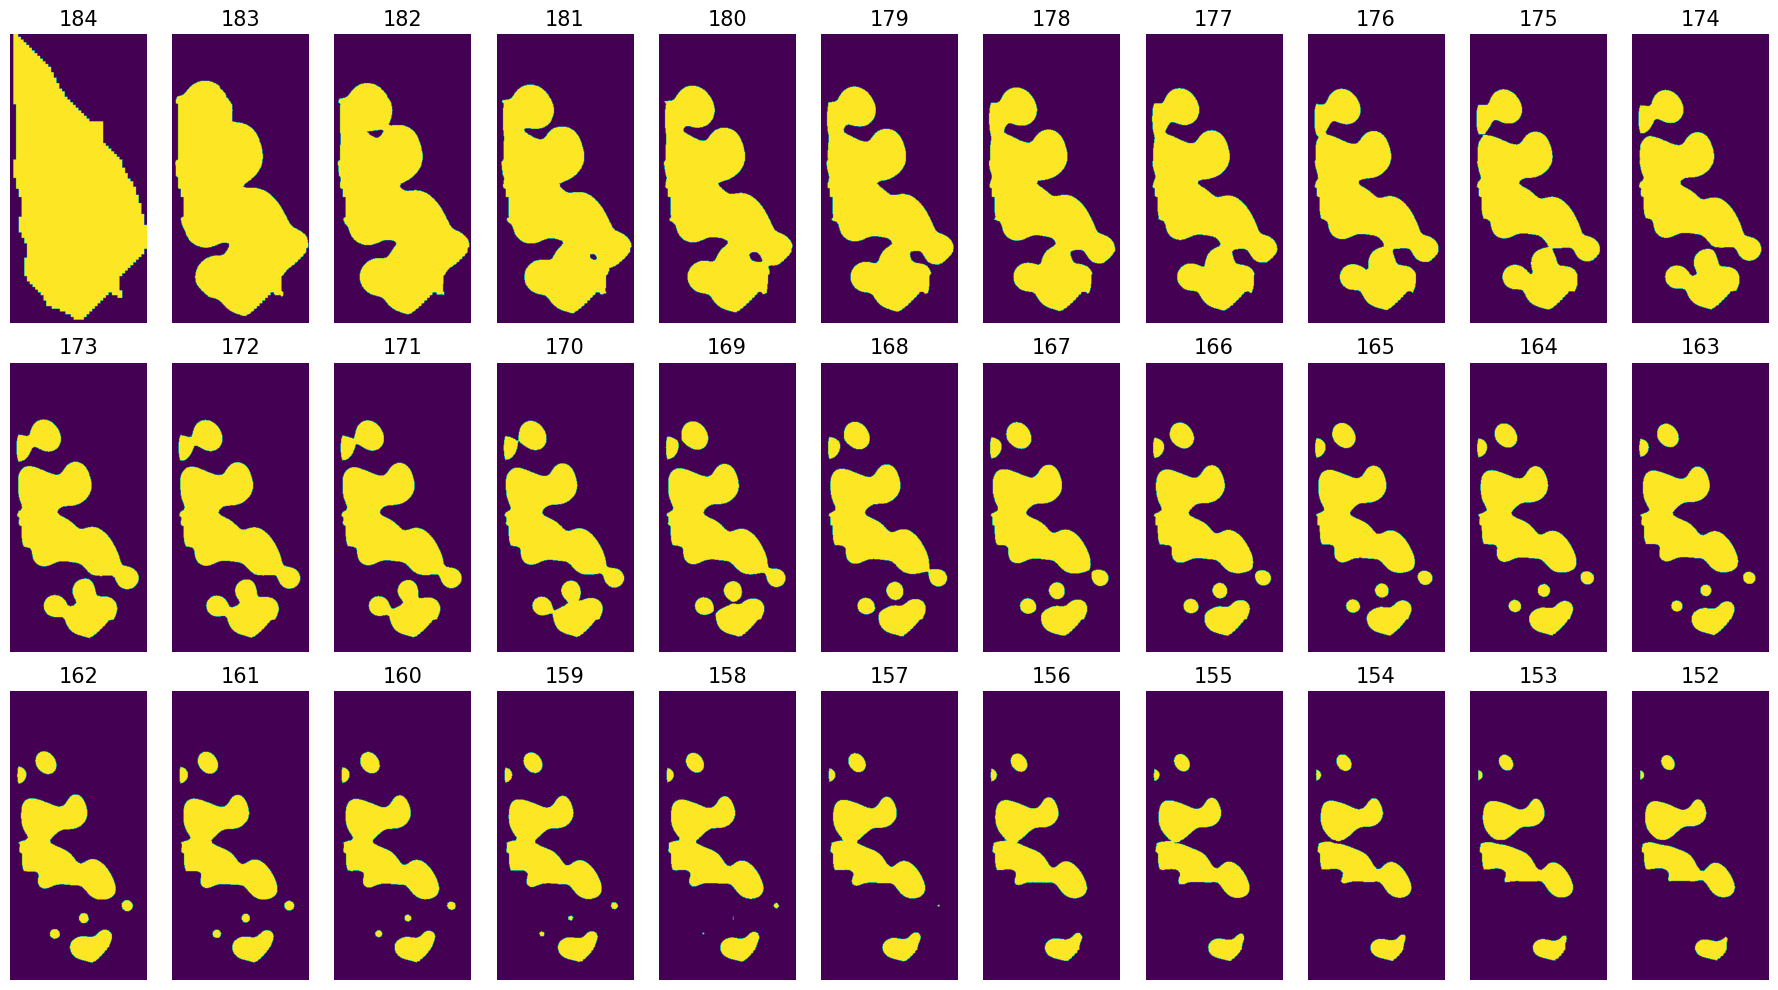

In [142]:
fig, ax = plt.subplots(3,11, figsize=(18,10), sharex=True, sharey=True)
ax = ax.ravel()
k = maxv - ax.size

for i in range(len(ax)):
    j = len(ax) - 1 - i
    ax[j].imshow(maxv-img <= k + i, vmin=0, vmax=1, origin='lower');
    ax[j].set_title(k + i, fontsize=15)
    ax[j].axis('off');

fig.tight_layout();

In [75]:

filename

'../gudhi/D2/BAC45727_c1730_p6_s5_b15.json'

In [76]:
filename = sdst + transcriptomes[tidx] + '_' + '_'.join(os.path.splitext(os.path.split(kdefiles[idx])[1])[0].split('_')[:-1]) + '.json'
with open(filename, 'w') as f:
    json.dump(pers,f)